## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\benja\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 128], drp_ratio=0.2, drop_bool=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if drop_bool:
                x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            if drop_bool:
                x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.25
layers = [
    [128, 64, 128],
    [128, 64, 256, 128]
]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for layer in layers:
    for drop_bool in [True, False]:
        model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP, num_neurons=layer, drop_bool=drop_bool)
        model.summary()
        #optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        # Collect results
        exp_name_tag = "l= {} drop= {}".format(len(layer), drop_bool)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\benja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-d212f69a2984>", line 17, in <module>
    shuffle=True)
  File "C:\Users\benja\Anaconda3\lib\site-packages\keras\engine\training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "C:\Users\benja\Anaconda3\lib\site-packages\keras\engine\training_arrays.py", line 185, in fit_loop
    ins[:-1], batch_ids) + [ins[-1]]
  File "C:\Users\benja\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 526, in slice_arrays
    return [None if x is None else x[start] for x in arrays]
  File "C:\Users\benja\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 526, in <listcomp>
    return [None if x is None else x[start] for x in arrays]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most rec

KeyboardInterrupt: 

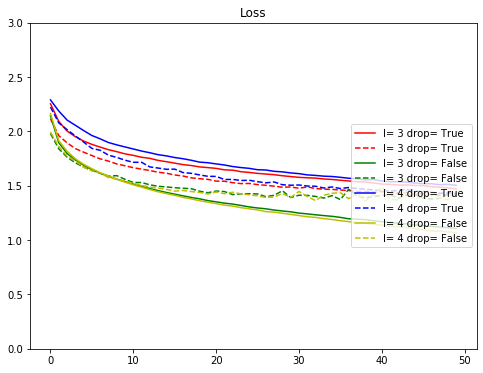

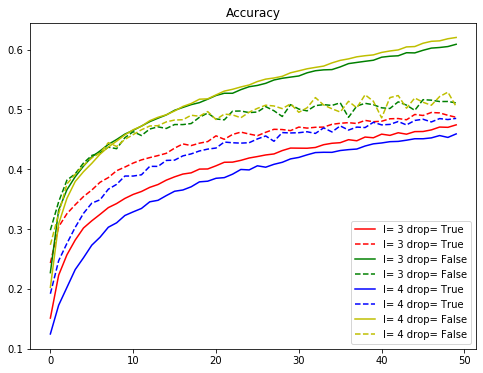

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend(loc='right')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [45]:
aa = {}

optimizers = [
    keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
]
names = ['Adam', 'SGD']
for drop_bool in [True, False]:
    for optimizer, name in zip(optimizers, names):
        model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP, num_neurons=[128, 64, 128], drop_bool=drop_bool)
        model.summary()
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        # Collect results
        exp_name_tag = "opt {}, drop {}".format(name, drop_bool)
        aa[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
__________

50000/50000 [==============================] - 8s 156us/step - loss: 1.4937 - acc: 0.4635 - val_loss: 1.4297 - val_acc: 0.4894
Epoch 48/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.4879 - acc: 0.4676 - val_loss: 1.4206 - val_acc: 0.4911
Epoch 49/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.4833 - acc: 0.4662 - val_loss: 1.4138 - val_acc: 0.4932
Epoch 50/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.4860 - acc: 0.4704 - val_loss: 1.4151 - val_acc: 0.4938
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256 

Epoch 47/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.1239 - acc: 0.6015 - val_loss: 1.3768 - val_acc: 0.5186
Epoch 48/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.1156 - acc: 0.6066 - val_loss: 1.4122 - val_acc: 0.5115
Epoch 49/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.1098 - acc: 0.6050 - val_loss: 1.3661 - val_acc: 0.5200
Epoch 50/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.1021 - acc: 0.6096 - val_loss: 1.3930 - val_acc: 0.5136


dict_keys(['opt Adam, drop True', 'opt SGD, drop True', 'opt Adam, drop False', 'opt SGD, drop False'])


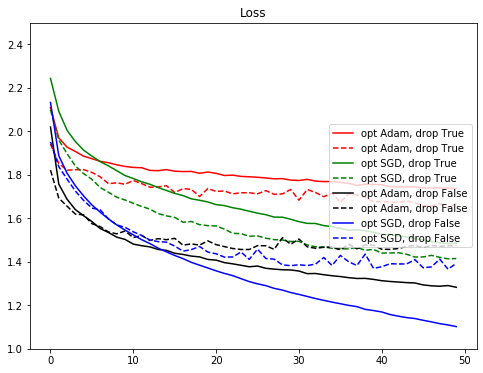

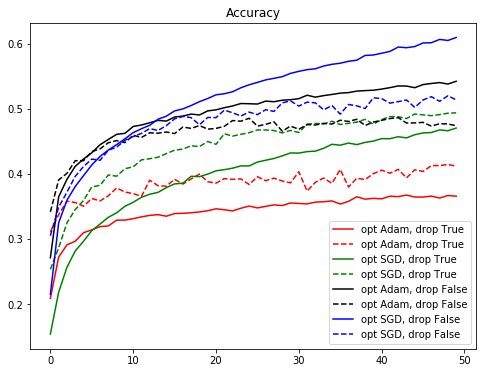

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", 'k', 'b']
print(aa.keys())

plt.figure(figsize=(8,6))
for i, cond in enumerate(aa.keys()):
    plt.plot(range(len(aa[cond]['train-loss'])),aa[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(aa[cond]['valid-loss'])),aa[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([1, 2.5])
plt.legend(loc='right')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(aa.keys()):
    plt.plot(range(len(aa[cond]['train-acc'])),aa[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(aa[cond]['valid-acc'])),aa[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()